In [ ]:
# PASSO 1: Instalar e importar bibliotecas necessárias
!pip install tensorflow tensorflow_datasets

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# PASSO 2: Carregar o dataset
# Documentação oficial: https://www.tensorflow.org/datasets/catalog/cats_vs_dogs
(ds_train, ds_validation, ds_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.2Z3IG2_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [ ]:
# PASSO 3: Pré-processamento dos dados
# Função para redimensionar e pré-processar as imagens
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

# Aplicar pré-processamento e configurar datasets
batch_size = 32
shuffle_buffer = 1000

train = ds_train.map(preprocess).shuffle(shuffle_buffer).batch(batch_size).prefetch(tf.data.AUTOTUNE)
validation = ds_validation.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test = ds_test.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
# PASSO 5: Configurar aumento de dados
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
])

In [ ]:
# PASSO 6: Criar modelo base MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Congelar camadas da base
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# PASSO 7: Construir o modelo completo
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)

In [ ]:
# PASSO 8: Compilar o modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# PASSO 9: Treinamento inicial
initial_epochs = 5
history = model.fit(
    train,
    epochs=initial_epochs,
    validation_data=validation
)

Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 1208s 2s/step - accuracy: 0.6065 - loss: 0.6958 - val_accuracy: 0.9579 - val_loss: 0.2323
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 1162s 2s/step - accuracy: 0.7945 - loss: 0.4254 - val_accuracy: 0.9669 - val_loss: 0.1518
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 1159s 2s/step - accuracy: 0.8219 - loss: 0.3755 - val_accuracy: 0.9690 - val_loss: 0.1230
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 1182s 2s/step - accuracy: 0.8299 - loss: 0.3574 - val_accuracy: 0.9703 - val_loss: 0.1095
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 1144s 2s/step - accuracy: 0.8404 - loss: 0.3399 - val_accuracy: 0.9746 - val_loss: 0.0994


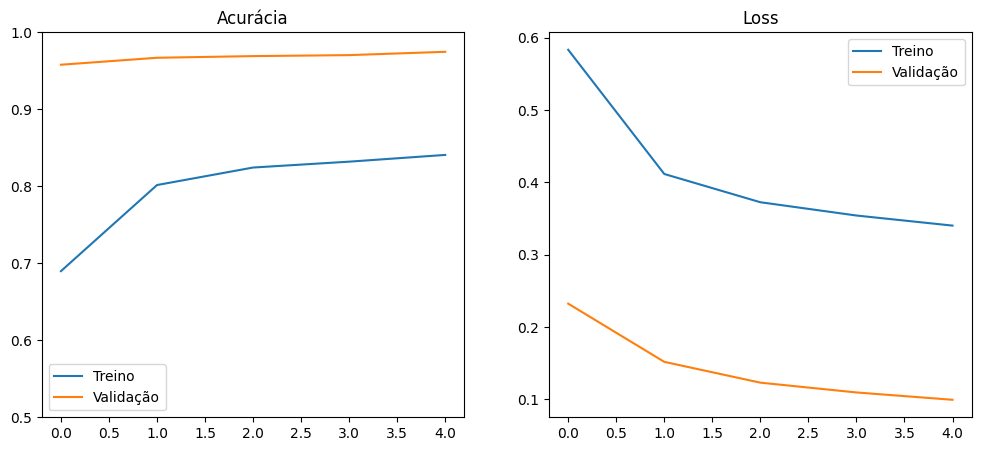

In [ ]:
# PASSO 10: Avaliação do modelo
# Plotar métricas de treinamento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Treino')
plt.plot(val_acc, label='Validação')
plt.title('Acurácia')
plt.ylim([0.5, 1])
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Treino')
plt.plot(val_loss, label='Validação')
plt.title('Loss')
plt.legend()
plt.show()


In [ ]:
# PASSO 11: Fine-tuning
# Descongelar parte do modelo base
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Continuar treinamento
fine_tune_epochs = 5
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=validation
)


Epoch 5/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 1724s 3s/step - accuracy: 0.8000 - loss: 0.4203 - val_accuracy: 0.9802 - val_loss: 0.0540
Epoch 6/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 1672s 3s/step - accuracy: 0.8683 - loss: 0.2908 - val_accuracy: 0.9798 - val_loss: 0.0517
Epoch 7/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 1650s 3s/step - accuracy: 0.8824 - loss: 0.2662 - val_accuracy: 0.9794 - val_loss: 0.0497
Epoch 8/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 1705s 3s/step - accuracy: 0.8924 - loss: 0.2420 - val_accuracy: 0.9785 - val_loss: 0.0526
Epoch 9/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 1696s 3s/step - accuracy: 0.9004 - loss: 0.2219 - val_accuracy: 0.9815 - val_loss: 0.0495
Epoch 10/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 1681s 3s/step - accuracy: 0.9078 - loss: 0.2134 - val_accuracy: 0.9798 - val_loss: 0.0521


In [ ]:
# PASSO 12: Avaliação final no conjunto de teste
test_loss, test_acc = model.evaluate(test)
print(f"\nAcurácia final no teste: {test_acc:.2%}")

73/73 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.9869 - loss: 0.0382

Acurácia final no teste: 98.50%


In [ ]:
# PASSO 13: Salvar o modelo (versão corrigida)
# Usando o formato nativo do Keras (.keras) ao invés de HDF5 (.h5)
model.save('cats_vs_dogs_mobilenetv2.keras')

In [ ]:
# PASSO 14: Função para prever novas imagens
def predict_image(image_path):
    img = tf.keras.utils.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

    prediction = model.predict(img_array, verbose=0)[0][0]
    confidence = prediction if prediction > 0.5 else 1 - prediction
    class_name = "Cachorro" if prediction > 0.5 else "Gato"

    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.title(f"Predição: {class_name}\nConfiança: {confidence:.2%}")
    plt.axis('off')
    plt.show()

    return class_name, confidence


Testando com novas imagens:


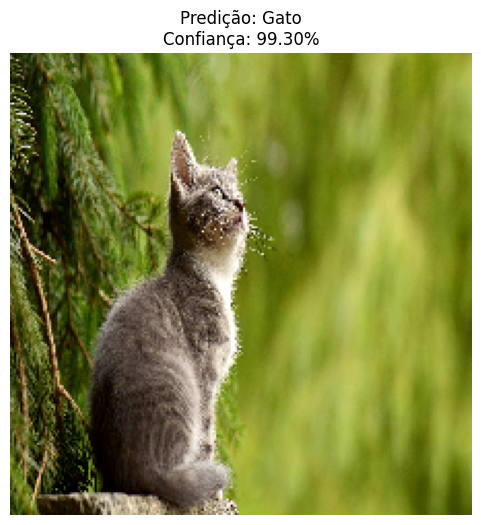

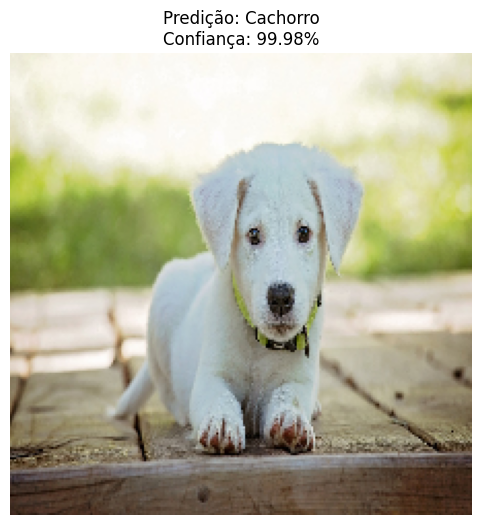

('Cachorro', 0.99979025)

In [ ]:
# 15. Teste com imagens externas

!wget -q -O test_cat.jpg https://cdn.pixabay.com/photo/2017/02/20/18/03/cat-2083492_1280.jpg
!wget -q -O test_dog.jpg https://cdn.pixabay.com/photo/2016/12/13/05/15/puppy-1903313_1280.jpg

print("Testando com novas imagens:")
predict_image('test_cat.jpg')
predict_image('test_dog.jpg')